# Libraries

In [55]:
from google.colab import drive
from google.colab import files

import calendar
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from IPython.core.display import display

from sklearn.cluster import KMeans

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn import metrics
from sklearn.metrics import recall_score # Import recall_score explicitly as it's used directly
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_pinball_loss

# Data read in

In [56]:
drive.mount('/content/drive')
file_path1 = "/content/drive/MyDrive/IOE 424 (Gemline)/Models/Demand Forest/2. Sales profile and demand for SKUs/monthly_sales.xlsx"
file_path2 = "/content/drive/MyDrive/IOE 424 (Gemline)/Data/SKU Data/SKU Attributes Report V3.xlsx"

df_monthly_sales = pd.read_excel(file_path1)
df_monthly_sales = df_monthly_sales.sort_values(by='Intro Date')

df_sku_attributes = pd.read_excel(file_path2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
df_items = df_monthly_sales[['Item']].copy()

# Split the DataFrame randomly
train_items, test_items = train_test_split(df_items, test_size=0.25, random_state=42)

# Display the shapes of the resulting DataFrames to verify the split
print("Training items shape:", train_items.shape)
print("Test items shape:", test_items.shape)

Training items shape: (518, 1)
Test items shape: (173, 1)


#SKU attributes

In [58]:
# Select the relevant columns for correlation analysis
cost_price_columns = ['Landed Cost', 'FOB Cost', 'Base Price']
df_cost_price = df_sku_attributes[cost_price_columns]

# Calculate the correlation matrix
correlation_matrix = df_cost_price.corr()

# Display the correlation matrix
display(correlation_matrix)

,Landed Cost,FOB Cost,Base Price
Landed Cost,1.000000,0.975271,0.884752
FOB Cost,0.975271,1.000000,0.879698
Base Price,0.884752,0.879698,1.000000


In [59]:
# Create a new DataFrame with the specified columns
df_demand_profile_sku_attributes = df_sku_attributes[[
  'Item',
  #'Description',
  #'Standard Name Description',
  'Category',
  'Sub-Category',
  #'Subcategory Desc',
  'CommGroup2 Desc',
  #'Status Code',
  #'Color',
  #'Material',
  #'Country of Origin',
  #'Intro Code',
  'Intro Month',
  #'Intro Year',
  #'Intro Date',
  #'Style',
  #'Brand',
  #'Landed Cost',
  #'FOB Cost',
  #'Base Price',
  #'Price Range'
  ]]

In [60]:
# Create a new DataFrame with the specified columns
df_total_demand_sku_attributes = df_sku_attributes[[
  'Item',
  #'Description',
  #'Standard Name Description',
  'Category',
  'Sub-Category',
  #'Subcategory Desc',
  #'CommGroup2 Desc',
  'Status Code',
  'Color',
  'Material',
  'Country of Origin',
  #'Intro Code',
  'Intro Month',
  #'Intro Year',
  #'Intro Date',
  'Style',
  'Brand',
  #'Landed Cost',
  #'FOB Cost',
  'Base Price',
  #'Price Range'
  ]]

#demand profiles

In [61]:
# Select the columns to normalize
cols_to_normalize = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Calculate the sum of the selected columns for each row
df_monthly_sales['Total_Sales'] = df_monthly_sales[cols_to_normalize].sum(axis=1)

# Normalize the selected columns by dividing by the total sales for each row
for col in cols_to_normalize:
    df_monthly_sales[col] = df_monthly_sales[col] / df_monthly_sales['Total_Sales']

# Drop the 'Total_Sales' column as it is no longer needed
df_monthly_sales.drop(columns=['Total_Sales'], inplace=True)

# Display the head of the modified DataFrame to show the normalized columns
display(df_monthly_sales.head())

,Item,Intro Date,1,2,3,4,5,6,7,8,9,10,11,12
43,101036-001,2022-01-01,0.169947,0.091215,0.079693,0.008321,0.000320,0.000160,0.000960,0.018243,0.389662,0.210274,0.026884,0.004321
45,101037-001,2022-01-01,0.002447,0.004544,0.213911,0.301293,0.003495,0.000000,0.000000,0.000000,0.000000,0.034953,0.206222,0.233135
58,101184-920,2022-01-01,0.000000,0.000000,0.000000,0.141957,0.576353,0.001483,0.002595,0.000741,0.000371,0.001112,0.094144,0.181245
57,101184-237,2022-01-01,0.001968,0.004427,0.000246,0.089769,0.108706,0.291933,0.028283,0.034678,0.026316,0.198721,0.175848,0.039105
56,101183-920,2022-01-01,0.000000,0.000434,0.000000,0.000434,0.190187,0.000434,0.000000,0.000000,0.101172,0.223187,0.463309,0.020842


In [62]:
# Select the Item column and demand profile columns
columns_to_split = ['Item'] + [i for i in range(1, 13)]
df_split = df_monthly_sales[columns_to_split].dropna(subset=[i for i in range(1, 13)])

# Split the data into training and testing sets
train_df_demand_profiles = df_split[df_split['Item'].isin(train_items['Item'])].copy()
test_df_demand_profiles = df_split[df_split['Item'].isin(test_items['Item'])].copy()

# Display the shapes of the resulting dataframes to verify the split
print("Training set shape:", train_df_demand_profiles.shape)
print("Test set shape:", test_df_demand_profiles.shape)

Training set shape: (515, 13)
Test set shape: (173, 13)


In [63]:
test_df_demand_profiles.head()

,Item,1,2,3,4,5,6,7,8,9,10,11,12
58,101184-920,0.000000,0.000000,0.000000,0.141957,0.576353,0.001483,0.002595,0.000741,0.000371,0.001112,0.094144,0.181245
54,101182-130,0.002257,0.003868,0.000161,0.411992,0.168923,0.057382,0.000000,0.000000,0.056738,0.056093,0.155867,0.086718
37,101033-001,0.001934,0.060606,0.023856,0.121642,0.424457,0.000860,0.001075,0.000645,0.000645,0.059102,0.212121,0.093058
47,101038-001,0.001672,0.049816,0.171515,0.149894,0.113006,0.000000,0.000111,0.000557,0.089156,0.187005,0.093503,0.143765
96,101285-000,0.000000,0.000062,0.000000,0.461918,0.050340,0.044352,0.007111,0.000312,0.142599,0.185640,0.079596,0.028071


Finds most similar sales distribution by using averages as opposed to clustering

In [64]:
# Create the two-column DataFrame
train_df_demand_profiles = pd.DataFrame({
    "Item": train_df_demand_profiles["Item"],
    "Cluster": train_df_demand_profiles.loc[:, 1:12].values.tolist()
})

print(train_df_demand_profiles.head())

          Item                                            Cluster
43  101036-001  [0.1699471915506481, 0.09121459433509362, 0.07...
45  101037-001  [0.002446696959105208, 0.004543865781195386, 0...
57  101184-237  [0.001967535661583866, 0.004426955238563699, 0...
56  101183-920  [0.0, 0.0004342162396873643, 0.0, 0.0004342162...
55  101183-237  [0.0013726835964310226, 0.007206588881262869, ...


In [65]:
merged_df = pd.merge(train_df_demand_profiles, df_demand_profile_sku_attributes, on='Item', how='inner')

# Display the head of the merged DataFrame
display(merged_df.head())

,Item,Cluster,Category,Sub-Category,CommGroup2 Desc,Intro Month
0,101036-001,"[0.1699471915506481, 0.09121459433509362, 0.07...",TOTE,1EVT,Promo,1
1,101037-001,"[0.002446696959105208, 0.004543865781195386, 0...",TRAVL,1ORG,Toiletry Bag,1
2,101184-237,"[0.001967535661583866, 0.004426955238563699, 0...",OUTDR,1PAPI,Cocktail Accessories,1
3,101183-920,"[0.0, 0.0004342162396873643, 0.0, 0.0004342162...",TOTE,1EVRD,All Purpose,1
4,101183-237,"[0.0013726835964310226, 0.007206588881262869, ...",TOTE,1EVRD,All Purpose,1


## decison tree model

### preparing data for modeling

In [66]:
merged_df['Intro Month'] = merged_df['Intro Month'].astype('category')

In [67]:
#Separating target variable and other variables
y_train = merged_df['Cluster']#write your code here
x_train = merged_df.drop(columns={'Cluster'})#write your code here

In [68]:
#Creating dummy variables
#drop_first=True is used to avoid redundant variables
x_train = pd.get_dummies(x_train, drop_first=True)

In [69]:
y_train = np.vstack(merged_df['Cluster'].values)

In [70]:
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [71]:
#Uses a regressor instead
# Choose the type of classifier
tree = RandomForestRegressor(min_samples_leaf = 5)

# Fit the best algorithm to the data
tree.fit(x_train, y_train)

RandomForestRegressor(min_samples_leaf=5)

<Axes: xlabel='Importance', ylabel='None'>

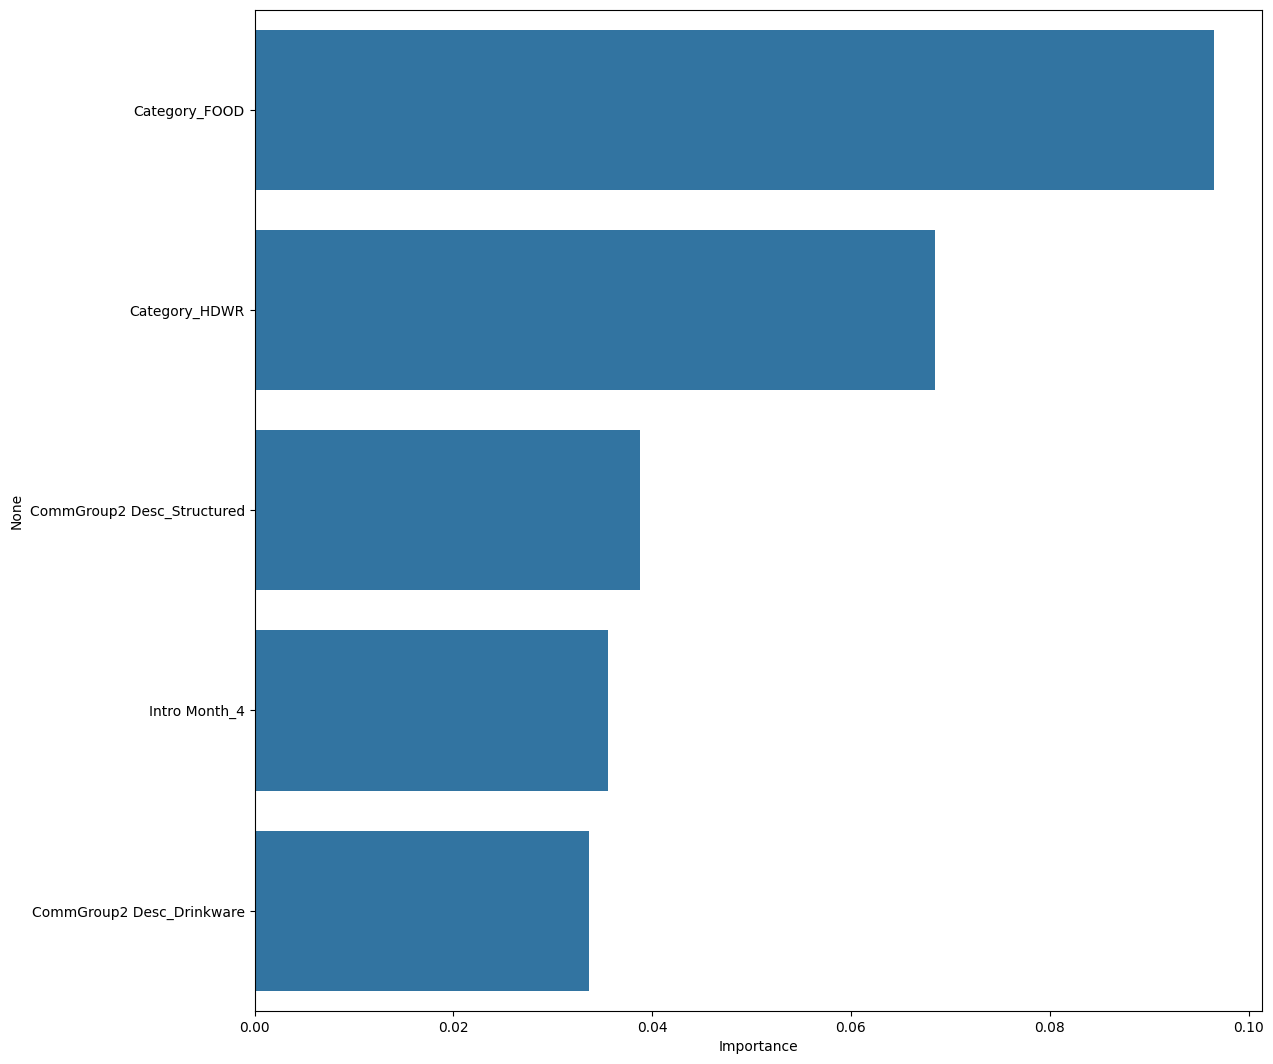

In [72]:
importances = tree.feature_importances_
columns=x_train.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(13,13))
sns.barplot(x=importance_df.Importance.head(5),y=importance_df.index[:5])

### Preparing test data for modeling

In [73]:
# Merge test demand profiles with SKU attributes
merged_test_df = pd.merge(test_df_demand_profiles, df_demand_profile_sku_attributes, on='Item', how='inner')

# Drop the 'Item' column
merged_test_df.drop(columns=['Item'], inplace=True)

# Convert 'Intro Month' to categorical
merged_test_df['Intro Month'] = merged_test_df['Intro Month'].astype('category')

# Create dummy variables
merged_test_df = pd.get_dummies(merged_test_df, drop_first=False)

# Separate target variable and other variables (assuming 'Cluster' is in the test data)
# Note: We don't have 'Cluster' in the original test_df_demand_profiles,
# so we'll only create x_test. If you have true labels for test data,
# you would create y_test similarly.
x_test = merged_test_df.copy()

# Align columns of test data with training data - this is crucial for consistent features
# Add missing columns in x_test that are present in x_train (fill with 0)
missing_cols = set(x_train.columns) - set(x_test.columns)
for c in missing_cols:
    x_test[c] = 0

# Drop columns in x_test that are not in x_train
extra_cols = set(x_test.columns) - set(x_train.columns)
x_test = x_test.drop(columns=extra_cols)

# Ensure the order of columns is the same
x_test = x_test[x_train.columns]

print("Prepared test data shape:", x_test.shape)

Prepared test data shape: (173, 686)


/tmp/ipython-input-3081821823.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[c] = 0
/tmp/ipython-input-3081821823.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[c] = 0
/tmp/ipython-input-3081821823.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[c] = 0
/tmp/ipyth

In [74]:
non_zero_count = (x_test != 0).sum().sum()
print(f"Number of non-zero values in x_test: {non_zero_count}")

Number of non-zero values in x_test: 627


### Predicting on test data

In [75]:
# Predict the clusters for the test data
y_pred = tree.predict(x_test)

# Display the predictions
display(y_pred[:10]) # Display first 10 predictions as an example

array([[0.0181538 , 0.04024965, 0.08590093, 0.08279425, 0.10871683,
        0.07353156, 0.06401305, 0.11788261, 0.12623036, 0.11114272,
        0.08424899, 0.08713525],
       [0.01121614, 0.04914681, 0.16455238, 0.13195318, 0.14644216,
        0.08972662, 0.06679735, 0.06438894, 0.06335869, 0.05698403,
        0.08570013, 0.06973356],
       [0.01255625, 0.05564084, 0.16971041, 0.13816933, 0.11614386,
        0.07026578, 0.08841752, 0.08934357, 0.0575203 , 0.07406112,
        0.06847712, 0.0596939 ],
       [0.01343153, 0.02392614, 0.11988528, 0.12890192, 0.09933224,
        0.09722521, 0.06327614, 0.07035543, 0.08923516, 0.10974124,
        0.09221341, 0.0924763 ],
       [0.01711094, 0.05599699, 0.09472551, 0.1169345 , 0.13259127,
        0.0913429 , 0.06696772, 0.12026951, 0.04751685, 0.09089636,
        0.0928133 , 0.07283414],
       [0.01598427, 0.07467814, 0.19104726, 0.07308416, 0.09775433,
        0.10280351, 0.07992969, 0.09093219, 0.0516595 , 0.07067295,
        0.08010939,

In [76]:
# Define the demand profile columns
demand_profile_columns = [i for i in range(1, 13)]

In [77]:
# Create a new DataFrame with Item, predicted cluster, and actual demand profile
demand_profile_results_df = test_df_demand_profiles[['Item'] + demand_profile_columns].copy()
demand_profile_results_df['Predicted_Profile'] = y_pred.tolist()

# Display the head of the new DataFrame
display(demand_profile_results_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12,Predicted_Profile
58,101184-920,0.000000,0.000000,0.000000,0.141957,0.576353,0.001483,0.002595,0.000741,0.000371,0.001112,0.094144,0.181245,"[0.018153795150958125, 0.04024965062111287, 0...."
54,101182-130,0.002257,0.003868,0.000161,0.411992,0.168923,0.057382,0.000000,0.000000,0.056738,0.056093,0.155867,0.086718,"[0.011216143717987912, 0.04914680725827325, 0...."
37,101033-001,0.001934,0.060606,0.023856,0.121642,0.424457,0.000860,0.001075,0.000645,0.000645,0.059102,0.212121,0.093058,"[0.01255624881599434, 0.055640844120468706, 0...."
47,101038-001,0.001672,0.049816,0.171515,0.149894,0.113006,0.000000,0.000111,0.000557,0.089156,0.187005,0.093503,0.143765,"[0.01343153177319411, 0.023926139766467753, 0...."
96,101285-000,0.000000,0.000062,0.000000,0.461918,0.050340,0.044352,0.007111,0.000312,0.142599,0.185640,0.079596,0.028071,"[0.017110935039712862, 0.0559969930973012, 0.0..."


In [78]:
df = demand_profile_results_df

# Expand
pred_df = pd.DataFrame(df["Predicted_Profile"].tolist(),
                       columns=[i for i in range(1, 13)],
                       index=df.index)

# Drop old month cols and Predicted_Profile
df = df.drop(columns=[i for i in range(1, 13)] + ["Predicted_Profile"], errors='ignore')

# Attach the new columns
df = df.join(pred_df)

demand_profile_results_df = df

display(demand_profile_results_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
58,101184-920,0.018154,0.040250,0.085901,0.082794,0.108717,0.073532,0.064013,0.117883,0.126230,0.111143,0.084249,0.087135
54,101182-130,0.011216,0.049147,0.164552,0.131953,0.146442,0.089727,0.066797,0.064389,0.063359,0.056984,0.085700,0.069734
37,101033-001,0.012556,0.055641,0.169710,0.138169,0.116144,0.070266,0.088418,0.089344,0.057520,0.074061,0.068477,0.059694
47,101038-001,0.013432,0.023926,0.119885,0.128902,0.099332,0.097225,0.063276,0.070355,0.089235,0.109741,0.092213,0.092476
96,101285-000,0.017111,0.055997,0.094726,0.116935,0.132591,0.091343,0.066968,0.120270,0.047517,0.090896,0.092813,0.072834


# total demand

In [79]:
df_monthly_sales = pd.read_excel(file_path1)

In [80]:
df_monthly_sales['Total Sales'] = df_monthly_sales.iloc[:, 2:14].sum(axis=1)
df_monthly_sales = df_monthly_sales.drop(columns=[i for i in range(1, 13)])
display(df_monthly_sales.head())

,Item,Intro Date,Total Sales
0,100153-001,2024-01-01,3231
1,100154-001,2024-01-01,5959
2,100155-001,2024-01-01,4939
3,100176-777,2022-06-01,3531
4,100177-777,2022-06-01,4735


In [81]:
# Select the Item column and demand profile columns
columns_to_split = ['Item'] + ['Total Sales']
df_split = df_monthly_sales[columns_to_split]

# Split the data into training and testing sets
train_df_total_demand = df_split[df_split['Item'].isin(train_items['Item'])].copy()
test_df_total_demand = df_split[df_split['Item'].isin(test_items['Item'])].copy()

# Display the shapes of the resulting dataframes to verify the split
print("Training set shape:", train_df_total_demand.shape)
print("Test set shape:", test_df_total_demand.shape)

Training set shape: (518, 2)
Test set shape: (173, 2)


## model

In [82]:
merged_df = pd.merge(train_df_total_demand, df_total_demand_sku_attributes, on='Item', how='inner')

In [83]:
merged_df.drop(columns=['Item'], inplace=True)

In [84]:
#Separating target variable and other variables
y_train = merged_df['Total Sales']#write your code here
x_train = merged_df.drop(columns={'Total Sales'})#write your code here

In [85]:
#Creating dummy variables
#drop_first=True is used to avoid redundant variables
x_train = pd.get_dummies(x_train, drop_first=True)

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_pinball_loss

In [87]:
# Choose the type of regressor
#look into adding random state if accuracy doesn't increase enough
q10 = GradientBoostingRegressor(loss="quantile",
                                alpha=0.1,
                                random_state=1,
                                learning_rate=0.01,
                                max_depth=4,
                                min_samples_leaf = 10,
                                n_estimators=100)

# Fit the best algorithm to the data
q10.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.1, learning_rate=0.01, loss='quantile',
                          max_depth=4, min_samples_leaf=10, random_state=1)

In [88]:
# Choose the type of regressor
q50 = GradientBoostingRegressor(loss="quantile",
                                alpha=0.5,
                                random_state=1,
                                learning_rate=0.1,
                                max_depth=4,
                                min_samples_leaf = 10,
                                n_estimators=300)

# Fit the best algorithm to the data
q50.fit(x_train, y_train)

GradientBoostingRegressor(alpha=0.5, loss='quantile', max_depth=4,
                          min_samples_leaf=10, n_estimators=300,
                          random_state=1)

In [89]:
# Choose the type of regressor
q90 = GradientBoostingRegressor(loss="quantile",
                                alpha=0.9,
                                random_state=1,
                                learning_rate=0.01,
                                max_depth=4,
                                min_samples_leaf = 10,
                                n_estimators=300)

# Fit the best algorithm to the data
q90.fit(x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, loss='quantile', max_depth=4,
                          min_samples_leaf=10, n_estimators=300,
                          random_state=1)

<Axes: xlabel='Importance', ylabel='None'>

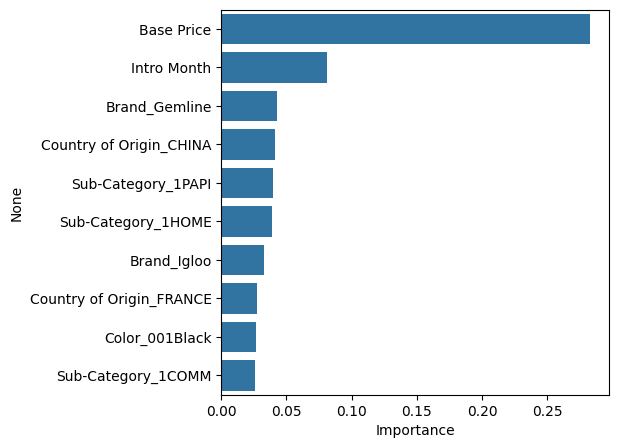

In [90]:
importances = q50.feature_importances_
columns=x_train.columns
importance_df=pd.DataFrame(importances,index=columns,columns=['Importance']).sort_values(by='Importance',ascending=False)
plt.figure(figsize=(5,5))
sns.barplot(x=importance_df.Importance.head(10),y=importance_df.index[:10])

In [91]:
# --- Clean and merge ---
test_df_total_demand['Item'] = test_df_total_demand['Item'].astype(str).str.strip().str.upper()
df_total_demand_sku_attributes['Item'] = df_total_demand_sku_attributes['Item'].astype(str).str.strip().str.upper()

merged_test_df = pd.merge(
    test_df_total_demand,
    df_total_demand_sku_attributes,
    on='Item',
    how='inner'
).drop(columns=['Item'])

# --- Optional: reduce fragmentation from categorical columns ---
for col in merged_test_df.select_dtypes('object'):
    top_categories = merged_test_df[col].value_counts().nlargest(10).index
    merged_test_df[col] = np.where(merged_test_df[col].isin(top_categories), merged_test_df[col], 'Other')

# --- Create dummies consistent with training ---
x_test = pd.get_dummies(merged_test_df)
x_test = x_test.reindex(columns=x_train.columns, fill_value=0)

print("Prepared test data shape:", x_test.shape)

Prepared test data shape: (173, 607)


/tmp/ipython-input-4232445436.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total_demand_sku_attributes['Item'] = df_total_demand_sku_attributes['Item'].astype(str).str.strip().str.upper()


In [92]:
# Predict the clusters for the test data
y_pred_q10 = q10.predict(x_test)
y_pred_q50 = q50.predict(x_test)
y_pred_q90 = q90.predict(x_test)

# Widen the interval by 10%
widen_factor = 0.1
y_pred_q10 = y_pred_q50 - (y_pred_q50 - y_pred_q10) * (1 + widen_factor)
y_pred_q90 = y_pred_q50 + (y_pred_q90 - y_pred_q50) * (1 + widen_factor)

# Display the predictions
display(y_pred_q50[:10]) # Display first 10 predictions as an example

array([2719.56867706, 4560.76203051, 4091.74499265, 1832.43360532,
       1558.87875415, 7620.1462017 , 3175.62665162, 2959.27197158,
       3231.5947251 , 2777.66324754])

In [93]:
# Create a new DataFrame with Item, predicted cluster, and actual demand profile
total_demand_results_df = test_df_total_demand[['Item'] + ['Total Sales']].copy()
total_demand_results_df['Predicted demand (q10)'] = y_pred_q10
total_demand_results_df['Predicted demand (q50)'] = y_pred_q50
total_demand_results_df['Predicted demand (q90)'] = y_pred_q90

# Display the head of the new DataFrame
display(total_demand_results_df.head(50))

,Item,Total Sales,Predicted demand (q10),Predicted demand (q50),Predicted demand (q90)
0,100153-001,3231,347.296631,2719.568677,6301.252060
1,100154-001,5959,163.177296,4560.762031,6641.191064
2,100155-001,4939,170.608606,4091.744993,6511.625212
7,100276-791,6435,37.817990,1832.433605,5291.870287
9,100370-274,2143,418.798538,1558.878754,6262.156383
24,100804-275,6796,-132.457993,7620.146202,9505.184999
37,101033-001,4653,301.690834,3175.626652,6805.504574
38,101033-410,3687,318.229610,2959.271972,6596.814213
47,101038-001,8973,296.094027,3231.594725,6805.979248
48,101038-410,12079,336.390483,2777.663248,6621.046567


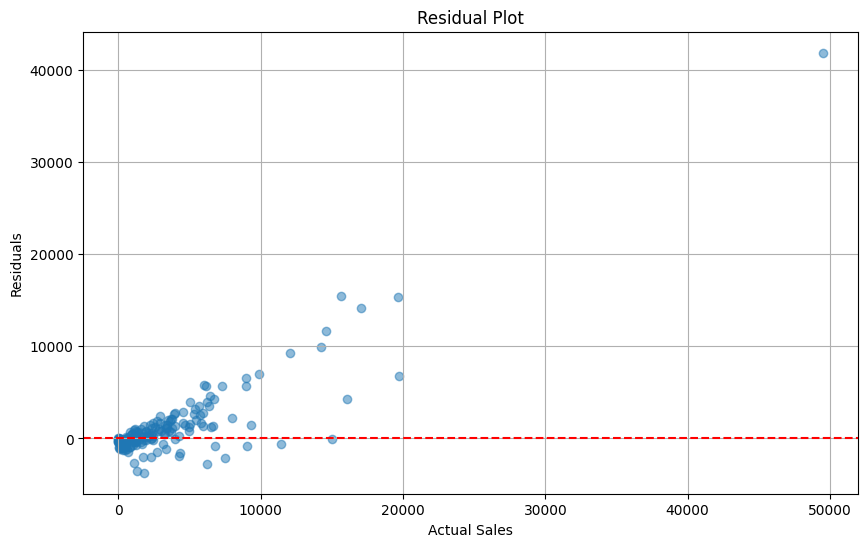

In [94]:
# Calculate residuals
total_demand_results_df['Residuals'] = total_demand_results_df['Total Sales'] - total_demand_results_df['Predicted demand (q50)']

# Create residual plot
plt.figure(figsize=(10, 6))
plt.scatter(total_demand_results_df['Total Sales'], total_demand_results_df['Residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.show()

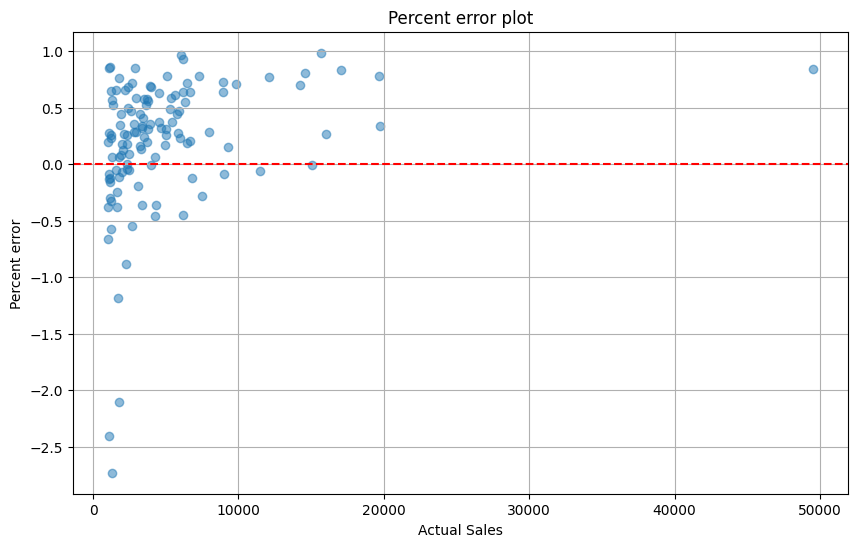

In [95]:
# Calculate residuals
total_demand_results_df['Percent error'] = (total_demand_results_df['Total Sales'] - total_demand_results_df['Predicted demand (q50)']) / total_demand_results_df['Total Sales']

# Filter data for sales above 5000
filtered_results_df = total_demand_results_df[total_demand_results_df['Total Sales'] > 1000].copy()

# Create residual plot using the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_results_df['Total Sales'], filtered_results_df['Percent error'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Sales')
plt.ylabel('Percent error')
plt.title('Percent error plot')
plt.grid(True)
plt.show()

In [96]:
cols_to_drop = ['Total Sales', 'Residuals', 'Percent error']
existing_cols_to_drop = [col for col in cols_to_drop if col in total_demand_results_df.columns]
if existing_cols_to_drop:
    total_demand_results_df = total_demand_results_df.drop(columns=existing_cols_to_drop)
display(total_demand_results_df.head())

,Item,Predicted demand (q10),Predicted demand (q50),Predicted demand (q90)
0,100153-001,347.296631,2719.568677,6301.252060
1,100154-001,163.177296,4560.762031,6641.191064
2,100155-001,170.608606,4091.744993,6511.625212
7,100276-791,37.817990,1832.433605,5291.870287
9,100370-274,418.798538,1558.878754,6262.156383


# combined

## predicted

In [97]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q90)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q90)
high_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q90)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    high_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q90)']

# Display the head of the new DataFrame
display(high_monthly_sales_pred_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,101184-920,127.994940,283.783724,605.652077,583.748221,766.517665,518.440775,451.329698,831.141760,889.998349,783.621576,594.004926,614.354803
1,101182-130,66.876648,293.039552,981.149317,786.775424,873.166510,534.998097,398.281499,383.921320,377.778419,339.769278,510.990020,415.788791
2,101033-001,85.451609,378.664019,1154.964989,940.311977,790.417552,478.194101,601.725852,608.028072,391.454671,504.023282,466.021373,406.247080
3,101038-001,91.414727,162.840811,815.936715,877.303784,676.053170,661.712748,430.656098,478.837594,607.332641,746.896635,627.602572,629.391755
4,101285-000,315.441962,1032.310703,1746.275194,2155.700402,2444.334599,1683.916386,1234.557323,2217.181567,875.978355,1675.684379,1711.023329,1342.705371


In [98]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q50)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q50)
medium_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q50)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    medium_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q50)']

# Display the head of the new DataFrame
display(medium_monthly_sales_pred_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,101184-920,75.554945,167.516496,357.514209,344.584443,452.472578,306.033696,266.418273,490.619946,525.362775,462.568955,350.638939,362.651397
1,101182-130,25.329017,110.986479,371.602767,297.985148,330.705108,202.626419,150.846058,145.407251,143.080674,128.685004,193.533545,157.476810
2,101033-001,39.873958,176.694548,538.936909,438.774193,368.829528,223.137890,280.781040,283.721821,182.663000,235.190462,217.457776,189.565526
3,101038-001,43.405267,77.319587,387.420632,416.558761,321.001546,314.192469,204.482841,227.360235,288.371869,354.639228,297.996378,298.845912
4,101285-000,200.502350,656.161026,1109.973691,1370.214008,1553.676710,1070.336963,784.713746,1409.292886,556.792498,1065.104505,1087.566775,853.455195


In [99]:
# Merge the demand profile results and total demand results DataFrames to align items
merged_pred_df = pd.merge(demand_profile_results_df, total_demand_results_df[['Item', 'Predicted demand (q10)']], on='Item', how='inner')

# Create a new DataFrame for predicted monthly sales (q10)
low_monthly_sales_pred_df = pd.DataFrame({'Item': merged_pred_df['Item']})

# Multiply the demand profile percentages by the predicted total demand (q10)
demand_profile_cols = [i for i in range(1, 13)]
for month in demand_profile_cols:
    low_monthly_sales_pred_df[month] = merged_pred_df[month] * merged_pred_df['Predicted demand (q10)']

# Display the head of the new DataFrame
display(low_monthly_sales_pred_df.head())

,Item,1,2,3,4,5,6,7,8,9,10,11,12
0,101184-920,3.873347,8.587785,18.328076,17.665227,23.196146,15.688911,13.658015,25.151782,26.932884,23.713740,17.975613,18.591435
1,101182-130,4.355569,19.085198,63.900689,51.241428,56.867941,34.843572,25.939438,25.004183,24.604105,22.128631,33.279964,27.079660
2,101033-001,3.788105,16.786333,51.200076,41.684419,35.039537,21.198542,26.674756,26.954136,17.353348,22.343561,20.658920,18.009101
3,101038-001,3.976996,7.084387,35.497315,38.167088,29.411683,28.787803,18.735687,20.831822,26.421998,32.493727,27.303841,27.381679
4,101285-000,-10.569700,-34.590244,-58.513474,-72.232326,-81.903763,-56.423981,-41.367041,-74.292412,-29.351924,-56.148146,-57.332269,-44.990822


## actual

In [100]:
df_monthly_sales = pd.read_excel(file_path1)

display(df_monthly_sales.head())

,Item,Intro Date,1,2,3,4,5,6,7,8,9,10,11,12
0,100153-001,2024-01-01,4,148,635,209,484,1,16,0,490,478,5,761
1,100154-001,2024-01-01,241,122,360,499,329,154,1728,1837,550,132,6,1
2,100155-001,2024-01-01,1005,11,2,0,0,367,120,488,1003,271,887,785
3,100176-777,2022-06-01,2,101,960,198,882,378,341,91,113,209,84,172
4,100177-777,2022-06-01,11,369,863,639,459,114,0,96,650,256,227,1051


## visual

In [101]:
# Ensure required dataframes exist:
# test_df_total_demand, high_monthly_sales_pred_df, medium_monthly_sales_pred_df,
# low_monthly_sales_pred_df, df_monthly_sales

# --- 1️⃣ Prepare actual monthly sales dataframe ---
monthly_sales_actual = df_monthly_sales.copy()
demand_profile_columns = [i for i in range(1, 13)]
rename_dict = {month: f'Actual_{month}' for month in demand_profile_columns}
monthly_sales_actual.rename(columns=rename_dict, inplace=True)

# --- 2️⃣ Prepare predicted monthly sales dataframes with proper suffixes ---
high_df = high_monthly_sales_pred_df.copy()
high_df.rename(columns={month: f'{month}_q90' for month in demand_profile_columns}, inplace=True)

medium_df = medium_monthly_sales_pred_df.copy()
medium_df.rename(columns={month: f'{month}_q50' for month in demand_profile_columns}, inplace=True)

low_df = low_monthly_sales_pred_df.copy()
low_df.rename(columns={month: f'{month}_q10' for month in demand_profile_columns}, inplace=True)

# --- 3️⃣ Merge all datasets on 'Item' ---
plot_data = test_df_total_demand[['Item']].copy()
plot_data = (
    plot_data
    .merge(high_df, on='Item', how='left')
    .merge(medium_df, on='Item', how='left')
    .merge(low_df, on='Item', how='left')
    .merge(monthly_sales_actual[['Item'] + list(rename_dict.values())], on='Item', how='left')
)

# --- 4️⃣ Define columns for plotting ---
months = list(range(1, 13))
high_cols = [f'{m}_q90' for m in months]
medium_cols = [f'{m}_q50' for m in months]
low_cols = [f'{m}_q10' for m in months]
actual_cols = [f'Actual_{m}' for m in months]

# --- 5️⃣ Convert all relevant columns to numeric to prevent dtype issues ---
for col in high_cols + medium_cols + low_cols + actual_cols:
    plot_data[col] = pd.to_numeric(plot_data[col], errors='coerce')

# --- 6️⃣ Drop rows with missing or invalid data ---
all_plot_cols = high_cols + medium_cols + low_cols + actual_cols
plot_data_filtered = plot_data.dropna(subset=all_plot_cols).copy()

print(f"Number of items with complete data: {plot_data_filtered.shape[0]}")

# --- 7️⃣ Plot for each item with confidence interval ---
for _, item_data in plot_data_filtered.iterrows():
    item = item_data['Item']

    plt.figure(figsize=(8, 5))

    high = item_data[high_cols].astype(float).values
    medium = item_data[medium_cols].astype(float).values
    low = item_data[low_cols].astype(float).values
    actual = item_data[actual_cols].astype(float).values

    # Confidence interval (shaded area)
    plt.fill_between(months, low, high, color='skyblue', alpha=0.3, label='Predicted Range (q10–q90)')

    # Median prediction line
    plt.plot(months, medium, color='blue', linewidth=2, label='Predicted Median (q50)')

    # Actual sales line
    plt.plot(months, actual, color='black', marker='o', linewidth=2, label='Actual Sales')

    # Formatting
    plt.xlabel('Months since intro')
    plt.ylabel('Sales')
    plt.title(f'Monthly Sales Prediction vs Actual for Item: {item}')
    plt.xticks(months)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

Statistics for monthly sales

In [102]:
# Assuming plot_data_filtered DataFrame is available from the previous step
# and contains columns for actual sales and predicted quantiles (q10, q50, q90)
# with appropriate suffixes (e.g., 'Actual_1', '1_q10', '1_q90')

months = list(range(1, 13))
low_cols = [f'{m}_q10' for m in months]
high_cols = [f'{m}_q90' for m in months]
actual_cols = [f'Actual_{m}' for m in months]

# Initialize a counter for the number of actual values within the predicted range
within_range_count = 0
total_count = 0

# Iterate through each row (item) in the filtered data
for index, item_data in plot_data_filtered.iterrows():
    # Get the actual and predicted values for the current item across all months
    actual_values = item_data[actual_cols].values
    low_pred_values = item_data[low_cols].values
    high_pred_values = item_data[high_cols].values

    # Iterate through each month's data for the current item
    for month_index in range(len(months)):
        actual = actual_values[month_index]
        low_pred = low_pred_values[month_index]
        high_pred = high_pred_values[month_index]

        # Check if the actual value falls within the predicted range (inclusive)
        if low_pred <= actual <= high_pred:
            within_range_count += 1

        total_count += 1

# Calculate the percentage of actual values within the predicted range
percentage_within_range = (within_range_count / total_count) * 100 if total_count > 0 else 0

print(f"Percentage of actual monthly sales within the predicted range (q10-q90): {percentage_within_range:.2f}%")

Percentage of actual monthly sales within the predicted range (q10-q90): 51.01%


In [103]:
# Assuming plot_data_filtered DataFrame is available from the previous step
# and contains columns for actual sales and predicted quantiles (q10, q50, q90)
# with appropriate suffixes (e.g., 'Actual_1', '1_q10', '1_q90')

# Merge plot_data_filtered with SKU attributes to get category information
accuracy_by_group_df = pd.merge(plot_data_filtered, df_sku_attributes[['Item', 'Category', 'Sub-Category', 'CommGroup2 Desc']], on='Item', how='left')


months = list(range(1, 13))
low_cols = [f'{m}_q10' for m in months]
high_cols = [f'{m}_q90' for m in months]
actual_cols = [f'Actual_{m}' for m in months]

# Initialize dictionaries to store counts for each category, subcategory, and commgroup2
within_range_counts_by_category = {}
total_counts_by_category = {}
within_range_counts_by_subcategory = {}
total_counts_by_subcategory = {}
within_range_counts_by_commgroup2 = {}
total_counts_by_commgroup2 = {}


# Iterate through each row (item) in the filtered data
for index, item_data in accuracy_by_group_df.iterrows():
    item_category = item_data['Category']
    item_subcategory = item_data['Sub-Category']
    item_commgroup2 = item_data['CommGroup2 Desc']

    # Initialize counts for the category if not already present
    if item_category not in within_range_counts_by_category:
        within_range_counts_by_category[item_category] = 0
        total_counts_by_category[item_category] = 0

    # Initialize counts for the subcategory if not already present
    if item_subcategory not in within_range_counts_by_subcategory:
        within_range_counts_by_subcategory[item_subcategory] = 0
        total_counts_by_subcategory[item_subcategory] = 0

    # Initialize counts for the commgroup2 if not already present
    if item_commgroup2 not in within_range_counts_by_commgroup2:
        within_range_counts_by_commgroup2[item_commgroup2] = 0
        total_counts_by_commgroup2[item_commgroup2] = 0


    # Get the actual and predicted values for the current item across all months
    actual_values = item_data[actual_cols].values
    low_pred_values = item_data[low_cols].values
    high_pred_values = item_data[high_cols].values

    # Iterate through each month's data for the current item
    for month_index in range(len(months)):
        actual = actual_values[month_index]
        low_pred = low_pred_values[month_index]
        high_pred = high_pred_values[month_index]


        # Check if the actual value falls within the predicted range (inclusive)
        if low_pred <= actual <= high_pred:
            within_range_counts_by_category[item_category] += 1
            within_range_counts_by_subcategory[item_subcategory] += 1
            within_range_counts_by_commgroup2[item_commgroup2] += 1


        total_counts_by_category[item_category] += 1
        total_counts_by_subcategory[item_subcategory] += 1
        total_counts_by_commgroup2[item_commgroup2] += 1


# Calculate the percentage within range for each category
accuracy_by_category = {}
for category in total_counts_by_category:
    if total_counts_by_category[category] > 0:
        accuracy_by_category[category] = (within_range_counts_by_category[category] / total_counts_by_category[category]) * 100
    else:
        accuracy_by_category[category] = 0  # Handle cases with no data for a category

# Calculate the percentage within range for each subcategory
accuracy_by_subcategory = {}
for subcategory in total_counts_by_subcategory:
    if total_counts_by_subcategory[subcategory] > 0:
        accuracy_by_subcategory[subcategory] = (within_range_counts_by_subcategory[subcategory] / total_counts_by_subcategory[subcategory]) * 100
    else:
        accuracy_by_subcategory[subcategory] = 0  # Handle cases with no data for a subcategory

# Calculate the percentage within range for each commgroup2
accuracy_by_commgroup2 = {}
for commgroup2 in total_counts_by_commgroup2:
    if total_counts_by_commgroup2[commgroup2] > 0:
        accuracy_by_commgroup2[commgroup2] = (within_range_counts_by_commgroup2[commgroup2] / total_counts_by_commgroup2[commgroup2]) * 100
    else:
        accuracy_by_commgroup2[commgroup2] = 0  # Handle cases with no data for a commgroup2


# Convert the results to a pandas Series for easier display
accuracy_category_series = pd.Series(accuracy_by_category)
accuracy_subcategory_series = pd.Series(accuracy_by_subcategory)
accuracy_commgroup2_series = pd.Series(accuracy_by_commgroup2)


# Display the accuracy by Category with percentage formatting
print("Percentage of actual monthly sales within the predicted range by Category:")
display(accuracy_category_series.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%'))

# Display the accuracy by Subcategory with percentage formatting
print("\nPercentage of actual monthly sales within the predicted range by Subcategory:")
display(accuracy_subcategory_series.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%'))

# Display the accuracy by CommGroup2 with percentage formatting
print("\nPercentage of actual monthly sales within the predicted range by CommGroup2 Desc:")
display(accuracy_commgroup2_series.sort_values(ascending=False).apply(lambda x: f'{x:.2f}%'))

Percentage of actual monthly sales within the predicted range by Category:


,0
TOTE,74.24%
PKG,69.44%
TECH,62.96%
UMBR,59.38%
HOME,58.97%
BACKP,58.33%
DRINK,55.56%
OUTDR,54.17%
COOL,50.69%
BLKTW,47.92%



Percentage of actual monthly sales within the predicted range by Subcategory:


,0
1WRT,91.67%
1BAR,83.33%
1EVRD,75.00%
1OTD,75.00%
1STK,75.00%
1ENTR,75.00%
1CAM,75.00%
1STRK,66.67%
1CHRG,66.67%
1HDEV,66.67%



Percentage of actual monthly sales within the predicted range by CommGroup2 Desc:


,0
Coasters,91.67%
Packable,91.67%
Jotter Box,91.67%
Wireless,83.33%
Wine Tumbler,83.33%
...,...
Oven Mitts,25.00%
Retractable,20.83%
Sling,20.00%
Drinkware,11.67%
